# Exam SIB course: 
## Diving into deep learning - theory and applications with PyTorch 
### Martin Schwill
### date: 2024-Nov-08

## Summary

This Jupyter notebook implements and trains a Convolutional Neural Network (CNN) for protein subcellular location prediction with pytorch. It leverages the code from `04_chest_Xray_CNN.ipynb` notebook to achieve similar or better performance compared to Feedforward Neural Network (FFN) with flattening layer from the `02_protein_subcellular_localisation_classifier.ipynb` notebook.

The CNN architecture has been optimized to prioritize the first 150 positions (rows) of the input data, as protein translocation signals are often located at the N-terminus. To achieve this, additional layers were incorporated into the network. This focused approach resulted in improved validation accuracy compared to a model that did not specifically target this region. Dropout regularization could be considered as an alternative approach to further enhance the model's performance and prevent overfitting.

**Resources:**

* Main repository: https://github.com/sib-swiss/pytorch-practical-training
* Protein subcellular localization classifier notebook: https://github.com/sib-swiss/pytorch-practical-training/blob/master/02_protein_subcellular_localisation_classifier.ipynb
* Chest X-ray CNN notebook (reference for implementation): https://github.com/sib-swiss/pytorch-practical-training/blob/master/04_chest_Xray_CNN.ipynb

In [1]:
# Dependencies
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import pytorch_model_summary as pms

from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics
import pandas as pd

In [2]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [3]:
# Load the encoded protein sequences and labels
train = np.load('data/subcellular_localization/reduced_train.npz')
X_train = train['X_train']
y_train = train['y_train']

print("train: ", train)
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

validation = np.load('data/subcellular_localization/reduced_val.npz')
X_valid = validation['X_val']
y_valid = validation['y_val']

print("validation: ", validation)
print("X_valid: ", X_valid.shape)
print("Y_valid: ", y_valid.shape)

classes = ['Nucleus',
           'Cytoplasm',
           'Extracellular',
           'Mitochondrion',
           'Cell membrane',
           'ER',
           'Chloroplast',
           'Golgi apparatus',
           'Lysosome',
           'Vacuole']

dico_classes_subcell = {i: v for i, v in enumerate(classes)}

train:  NpzFile 'data/subcellular_localization/reduced_train.npz' with keys: X_train, y_train, mask_train
X_train:  (2423, 400, 20)
y_train:  (2423,)
validation:  NpzFile 'data/subcellular_localization/reduced_val.npz' with keys: X_val, y_val, mask_val
X_valid:  (635, 400, 20)
Y_valid:  (635,)


In [4]:
print("Classes in data set: ")
for i in dico_classes_subcell.keys():
    print('Target', i, dico_classes_subcell[i])

Classes in data set: 
Target 0 Nucleus
Target 1 Cytoplasm
Target 2 Extracellular
Target 3 Mitochondrion
Target 4 Cell membrane
Target 5 ER
Target 6 Chloroplast
Target 7 Golgi apparatus
Target 8 Lysosome
Target 9 Vacuole


In [5]:
# Set batch size
batch_size = 128

# Create datasets and dataloaders
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train).long())
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid).long())
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# Alternative CNN Model focusing on the first 150 positions
class ProteinLoc_CNN_FocusFirst150(nn.Module):
    def __init__(self, num_classes=10):
        super(ProteinLoc_CNN_FocusFirst150, self).__init__()
        # Process the first 150 positions with more layers
        self.conv_first = nn.Sequential(
            nn.Conv1d(in_channels=20, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)
        )
        # Process the rest of the positions
        self.conv_rest = nn.Sequential(
            nn.Conv1d(in_channels=20, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)
        )
        # Combine features
        self.fc = nn.Sequential(
            nn.Linear(128 + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # x is (batch_size, 400, 20)
        x = x.transpose(1, 2)  # (batch_size, 20, 400)
        x_first = x[:, :, :150]  # (batch_size, 20, 150)
        x_rest = x[:, :, 150:]   # (batch_size, 20, 250)

        x_first = self.conv_first(x_first)  # (batch_size, 128, 1)
        x_rest = self.conv_rest(x_rest)     # (batch_size, 64, 1)

        x_first = x_first.squeeze(-1)  # (batch_size, 128)
        x_rest = x_rest.squeeze(-1)    # (batch_size, 64)

        x_combined = torch.cat((x_first, x_rest), dim=1)  # (batch_size, 192)

        out = self.fc(x_combined)
        return out

model = ProteinLoc_CNN_FocusFirst150(num_classes=10).to(device)
print(model)

ProteinLoc_CNN_FocusFirst150(
  (conv_first): Sequential(
    (0): Conv1d(20, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): AdaptiveMaxPool1d(output_size=1)
  )
  (conv_rest): Sequential(
    (0): Conv1d(20, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): AdaptiveMaxPool1d(output_size=1)
  )
  (fc): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [7]:
print(pms.summary(model, torch.zeros(1, 400, 20).to(device), show_input=True))

---------------------------------------------------------------------------
          Layer (type)         Input Shape         Param #     Tr. Param #
              Conv1d-1        [1, 20, 150]           3,904           3,904
                ReLU-2        [1, 64, 150]               0               0
              Conv1d-3        [1, 64, 150]          24,704          24,704
                ReLU-4       [1, 128, 150]               0               0
   AdaptiveMaxPool1d-5       [1, 128, 150]               0               0
              Conv1d-6        [1, 20, 250]           3,904           3,904
                ReLU-7        [1, 64, 250]               0               0
   AdaptiveMaxPool1d-8        [1, 64, 250]               0               0
              Linear-9            [1, 192]          24,704          24,704
               ReLU-10            [1, 128]               0               0
            Dropout-11            [1, 128]               0               0
             Linear-12  

In [8]:
# Compute class weights
W = torch.Tensor(compute_class_weight(class_weight='balanced',
                                      classes=np.array(list(range(10))),
                                      y=y_train)).to(device)
print('weights_classes', W.cpu().numpy())

CEloss = nn.CrossEntropyLoss(weight=W)

optimizer = torch.optim.AdamW(model.parameters(), # Note, AdamW was used
                             lr=1e-4,
                             weight_decay=1e-2)

weights_classes [0.71686393 0.42733687 0.4528972  1.0399141  0.85017544 3.8460317
 1.0816964  4.1067796  4.0383334  4.1067796 ]


In [9]:
# Performance metrics calculation
def get_additional_scores(predicted, target):
    return {'balanced_accuracy': metrics.balanced_accuracy_score(target, predicted),
            'accuracy': metrics.accuracy_score(target, predicted),
            'f1': metrics.f1_score(target, predicted, average='macro')}

def get_model_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return correct / total

In [10]:
# Function block: train and valid
def train(dataloader, model, loss_fn, optimizer, additional_score_function, echo=True, echo_batch=False):
    size = len(dataloader.dataset)
    model.train()

    all_predictions = []
    all_targets = []

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        all_predictions.extend(np.argmax(pred.detach().cpu().numpy(), axis=1))
        all_targets.extend(y.cpu().numpy())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if echo_batch:
            current = (batch + 1) * len(X)
            print(f"Train loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

    if echo:
        current = (batch + 1) * len(X)
        print(f"Train loss: {loss.item():>7f}")

    scores = additional_score_function(all_predictions, all_targets)
    scores['loss'] = loss.item()
    return scores

def valid(dataloader, model, loss_fn, additional_score_function, echo=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()

    all_predictions = []
    all_targets = []

    valid_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            valid_loss += loss_fn(pred, y).item()

            all_predictions.extend(np.argmax(pred.detach().cpu().numpy(), axis=1))
            all_targets.extend(y.cpu().numpy())

    valid_loss /= num_batches

    if echo:
        print(f"\tValid loss: {valid_loss:>8f}")
    scores = additional_score_function(all_predictions, all_targets)
    scores['loss'] = valid_loss
    return scores

In [11]:
# EarlyStopping class from https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
   
    def __init__(self, patience=25, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
     
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss  # Since we want to minimize val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)  # Save the first model
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)  # Save the model if val_loss decreases
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)  # Save the model
        self.val_loss_min = val_loss


In [12]:
# Initialize the EarlyStopping object
early_stopping = EarlyStopping(patience=25, verbose=False)

# Containers to keep the scores across all epochs
train_scores = defaultdict(list)
valid_scores = defaultdict(list)


In [13]:
%%time
# Training loop with early stopping
epochs = 500

for t in range(1, epochs+1):
    echo = t % 1 == 0  # Print every epoch
    if echo:
        print('Epoch', t)

    tmp_scores = train(train_dataloader,
                       model,
                       CEloss,
                       optimizer,
                       get_additional_scores,
                       echo=echo,
                       echo_batch=False)
    for k in tmp_scores:
        train_scores[k].append(tmp_scores[k])

    tmp_scores = valid(valid_dataloader,
                       model,
                       CEloss,
                       get_additional_scores,
                       echo=echo)
    for k in tmp_scores:
        valid_scores[k].append(tmp_scores[k])

    # Early stopping checks validation loss
    early_stopping(valid_scores['loss'][-1], model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

print("Done!")


Epoch 1
Train loss: 2.300317
	Valid loss: 2.299637
Epoch 2
Train loss: 2.296131
	Valid loss: 2.297989
Epoch 3
Train loss: 2.297391
	Valid loss: 2.296484
Epoch 4
Train loss: 2.290783
	Valid loss: 2.295211
Epoch 5
Train loss: 2.291697
	Valid loss: 2.293464
Epoch 6
Train loss: 2.286580
	Valid loss: 2.292088
Epoch 7
Train loss: 2.297824
	Valid loss: 2.290331
Epoch 8
Train loss: 2.282983
	Valid loss: 2.288523
Epoch 9
Train loss: 2.275494
	Valid loss: 2.286391
Epoch 10
Train loss: 2.290903
	Valid loss: 2.284165
Epoch 11
Train loss: 2.275251
	Valid loss: 2.281543
Epoch 12
Train loss: 2.287027
	Valid loss: 2.278424
Epoch 13
Train loss: 2.263860
	Valid loss: 2.275892
Epoch 14
Train loss: 2.265842
	Valid loss: 2.271113
Epoch 15
Train loss: 2.273255
	Valid loss: 2.267624
Epoch 16
Train loss: 2.251129
	Valid loss: 2.262808
Epoch 17
Train loss: 2.232609
	Valid loss: 2.257905
Epoch 18
Train loss: 2.235766
	Valid loss: 2.252197
Epoch 19
Train loss: 2.238374
	Valid loss: 2.245647
Epoch 20
Train loss: 

<timed exec>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


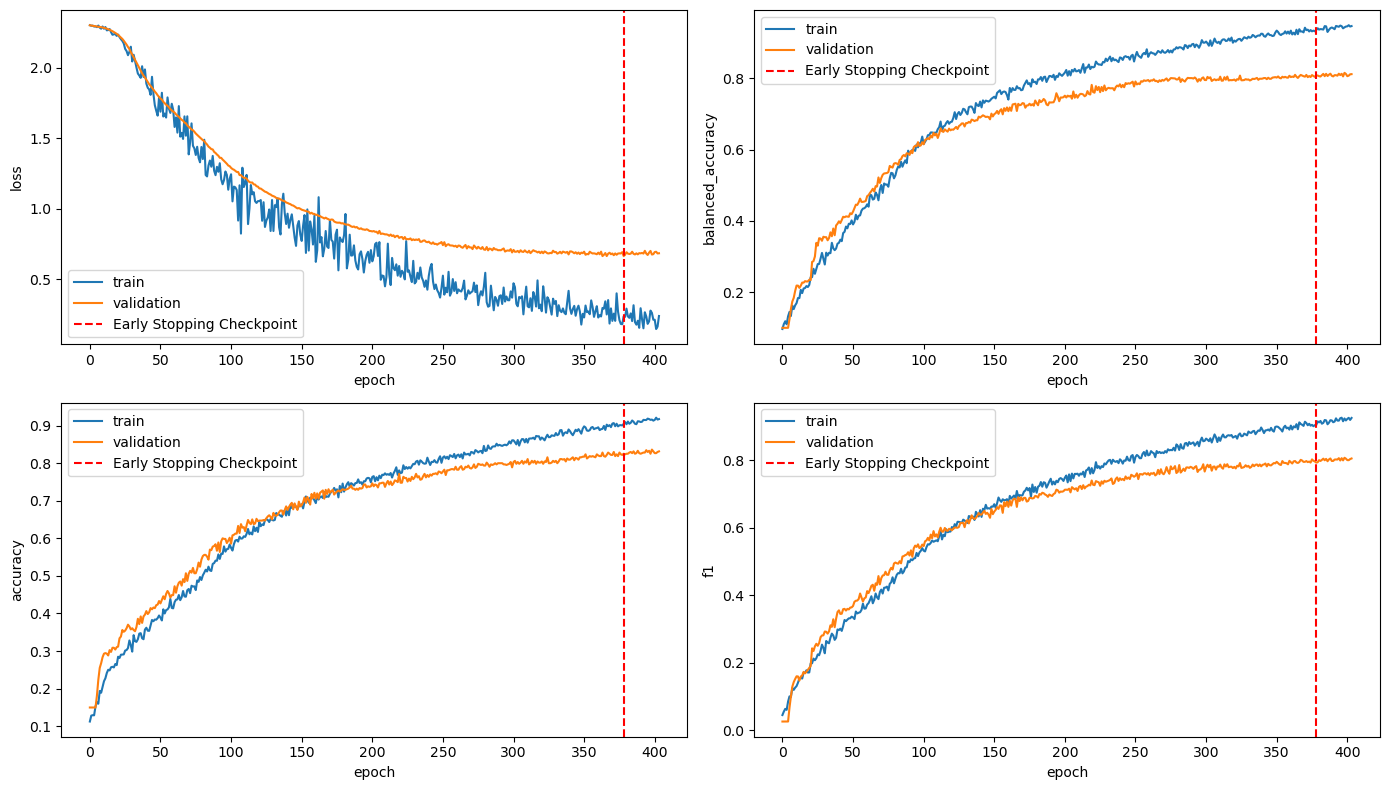

In [14]:
# Plotting the results with early stopping checkpoint
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

best_epoch = np.argmin(valid_scores['loss'])

for i, k in enumerate(['loss', 'balanced_accuracy', 'accuracy', 'f1']):
    axes[i // 2][i % 2].plot(train_scores[k], label='train')
    axes[i // 2][i % 2].plot(valid_scores[k], label='validation')
    axes[i // 2][i % 2].axvline(best_epoch, linestyle='--', color='r', label='Early Stopping Checkpoint')
    axes[i // 2][i % 2].legend()
    axes[i // 2][i % 2].set_xlabel('epoch')
    axes[i // 2][i % 2].set_ylabel(k)

plt.tight_layout()
plt.show()

In [15]:
# Compute and print final accuracies
train_accuracy = get_model_accuracy(model, train_dataloader)
valid_accuracy = get_model_accuracy(model, valid_dataloader)
print("Final train accuracy:", train_accuracy)
print("Final validation accuracy:", valid_accuracy)

Final train accuracy: 0.9356170037144036
Final validation accuracy: 0.8251968503937008


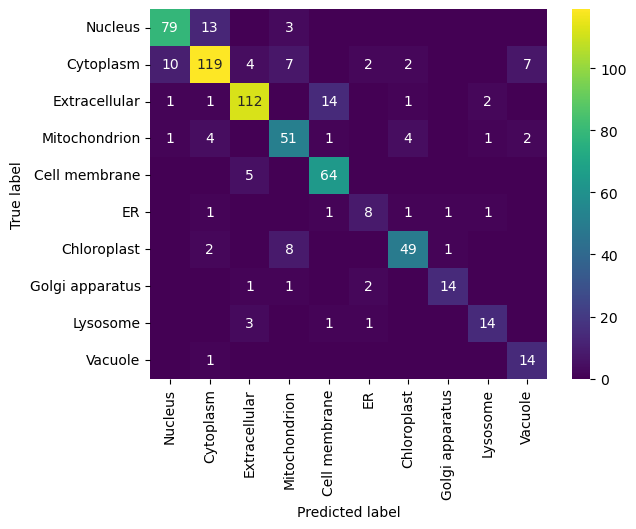

In [16]:
# Confusion matrix
y_pred = []

with torch.no_grad():
    for X_batch, _ in valid_dataloader:
        X_batch = X_batch.to(device)
        y_batch_pred = model(X_batch)
        y_pred_batch = np.argmax(y_batch_pred.cpu().numpy(), axis=1)
        y_pred.extend(y_pred_batch)

df = pd.crosstab(y_valid, y_pred, rownames=['truth'], colnames=['prediction'])
df.columns = classes
df.index = classes

sns.heatmap(df, annot=df.astype(str).replace('0', ''), fmt='s', cmap='viridis')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
import session_info
session_info.show()